<a href="https://colab.research.google.com/github/yoooobin/ESAA/blob/main/ESAA_OB_week7_2_markdown.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **07** 행렬 분해를 이용한 잠재 요인 협업 필터링 실습



- SGD 기반 행렬 분해를 구현 후, 사용자에게 영화를 추천


```
matrix_factorization(R, K, steps=200, learning_rate=0.01, r_lambda=0.01)
```
  - get_rmse() 함수 사용, 행렬 분해 로직을 새로운 matrix_factorization() 함수로 정리
- R = 원본 사용자-아이템 평점 행렬
- K = 잠재 요인의 차원 수
- steps = SGD 반복 횟수
- learning_rate = 학습률
- r_lambda = L2 규제 계수

In [1]:
import numpy as np
from sklearn.metrics import mean_squared_error

def get_rmse(R, P, Q, non_zeros):
    error = 0
    # 두개의 분해된 행렬 P와 Q.T의 내적 곱으로 예측 R 행렬 생성
    full_pred_matrix = np.dot(P, Q.T)

    # 실제 R 행렬에서 널이 아닌 값의 위치 인덱스 추출하여 실제 R 행렬과 예측 행렬의 RMSE 추출
    x_non_zero_ind = [non_zero[0] for non_zero in non_zeros]
    y_non_zero_ind = [non_zero[1] for non_zero in non_zeros]
    R_non_zeros = R[x_non_zero_ind, y_non_zero_ind]

    full_pred_matrix_non_zeros = full_pred_matrix[x_non_zero_ind, y_non_zero_ind]

    mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
    rmse = np.sqrt(mse)

    return rmse

In [2]:
def matrix_factorization(R, K, steps=200, learning_rate=0.01, r_lambda = 0.01):
    num_users, num_items = R.shape
    # P와 Q 매트릭스의 크기를 지정하고 정규분포를 가진 랜덤한 값으로 입력합니다.
    np.random.seed(1)
    P = np.random.normal(scale=1./K, size=(num_users, K))
    Q = np.random.normal(scale=1./K, size=(num_items, K))


    # R > 0 인 행 위치, 열 위치, 값을 non_zeros 리스트 객체에 저장.
    non_zeros = [ (i, j, R[i,j]) for i in range(num_users) for j in range(num_items) if R[i,j] > 0 ]


    # SGD기법으로 P와 Q 매트릭스를 계속 업데이트.
    for step in range(steps):
        for i, j, r in non_zeros:
            # 실제 값과 예측 값의 차이인 오류 값 구함
            eij = r - np.dot(P[i, :], Q[j, :].T)
            # Regularization을 반영한 SGD 업데이트 공식 적용
            P[i,:] = P[i,:] + learning_rate*(eij * Q[j, :] - r_lambda*P[i,:])
            Q[j,:] = Q[j,:] + learning_rate*(eij * P[i, :] - r_lambda*Q[j,:])


        rmse = get_rmse(R, P, Q, non_zeros)
        if (step % 10) == 0 :
            print("### iteration step : ", step," rmse : ", rmse)


    return P, Q

- 영화 평점 행렬 데이터 => DataFrame 로딩 => 다시 사용자-아이템 평점 행렬 생성

In [3]:
# 데이터 로드
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np

movies = pd.read_csv('/content/drive/MyDrive/ESAA/input/ml-latest-small/movies.csv')
ratings = pd.read_csv('/content/drive/MyDrive/ESAA/input/ml-latest-small/ratings.csv')
ratings = ratings[['userId', 'movieId', 'rating']]
ratings_matrix = ratings.pivot_table('rating', index='userId', columns='movieId')

# title 컬럼을 얻기 이해 movies 와 조인 수행
rating_movies = pd.merge(ratings, movies, on='movieId')

# columns='title' 로 title 컬럼으로 pivot 수행.
ratings_matrix = rating_movies.pivot_table('rating', index='userId', columns='title')

In [5]:
# 사용자-아이템 평점 행렬 matrix_factorization() 함수로 행렬 분해
P, Q = matrix_factorization(ratings_matrix.values, K=50, steps=200, learning_rate=0.01,
                            r_lambda = 0.01)
pred_matrix = np.dot(P, Q.T)

### iteration step :  0  rmse :  2.9023619751336867
### iteration step :  10  rmse :  0.7335768591017927
### iteration step :  20  rmse :  0.5115539026853442
### iteration step :  30  rmse :  0.37261628282537446
### iteration step :  40  rmse :  0.2960818299181014
### iteration step :  50  rmse :  0.2520353192341642
### iteration step :  60  rmse :  0.22487503275269854
### iteration step :  70  rmse :  0.2068545530233154
### iteration step :  80  rmse :  0.19413418783028685
### iteration step :  90  rmse :  0.18470082002720406
### iteration step :  100  rmse :  0.17742927527209104
### iteration step :  110  rmse :  0.1716522696470749
### iteration step :  120  rmse :  0.16695181946871726
### iteration step :  130  rmse :  0.16305292191997542
### iteration step :  140  rmse :  0.15976691929679646
### iteration step :  150  rmse :  0.1569598699945732
### iteration step :  160  rmse :  0.15453398186715425
### iteration step :  170  rmse :  0.15241618551077643
### iteration step :  180  rm

In [6]:
# 반환된 예측 사용자-아이템 평점 행렬 영화 타이틀 칼럼명 DataFrame으로 변경
ratings_pred_matrix = pd.DataFrame(data=pred_matrix, index=ratings_matrix.index,
                                   columns= ratings_matrix.columns)
ratings_pred_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,3.055084,4.092018,3.564130,4.502167,3.981215,1.271694,3.603274,2.333266,5.091749,3.972454,...,1.402608,4.208382,3.705957,2.720514,2.787331,3.475076,3.253458,2.161087,4.010495,0.859474
2,3.170119,3.657992,3.308707,4.166521,4.311890,1.275469,4.237972,1.900366,3.392859,3.647421,...,0.973811,3.528264,3.361532,2.672535,2.404456,4.232789,2.911602,1.634576,4.135735,0.725684
3,2.307073,1.658853,1.443538,2.208859,2.229486,0.780760,1.997043,0.924908,2.970700,2.551446,...,0.520354,1.709494,2.281596,1.782833,1.635173,1.323276,2.887580,1.042618,2.293890,0.396941


In [7]:
def get_unseen_movies(ratings_matrix, userId):
    # userId로 입력받은 사용자의 모든 영화정보 추출하여 Series로 반환함.
    # 반환된 user_rating 은 영화명(title)을 index로 가지는 Series 객체임.
    user_rating = ratings_matrix.loc[userId,:]

    # user_rating이 0보다 크면 기존에 관람한 영화임. 대상 index를 추출하여 list 객체로 만듬
    already_seen = user_rating[ user_rating > 0].index.tolist()

    # 모든 영화명을 list 객체로 만듬.
    movies_list = ratings_matrix.columns.tolist()

    # list comprehension으로 already_seen에 해당하는 movie는 movies_list에서 제외함.
    unseen_list = [ movie for movie in movies_list if movie not in already_seen]

    return unseen_list

In [8]:
def recomm_movie_by_userid(pred_df, userId, unseen_list, top_n=10):
    # 예측 평점 DataFrame에서 사용자id index와 unseen_list로 들어온 영화명 컬럼을 추출하여
    # 가장 예측 평점이 높은 순으로 정렬함.
    recomm_movies = pred_df.loc[userId, unseen_list].sort_values(ascending=False)[:top_n]
    return recomm_movies

In [9]:
# 사용자가 관람하지 않은 영화명 추출
unseen_list = get_unseen_movies(ratings_matrix, 9)

# 잠재 요인 협업 필터링으로 영화 추천
recomm_movies = recomm_movie_by_userid(ratings_pred_matrix, 9, unseen_list, top_n=10)

# 평점 데이터를 DataFrame 으로 생성
recomm_movies = pd.DataFrame(data=recomm_movies.values, index=recomm_movies.index,
                             columns=['pred_scores'])
recomm_movies

,pred_scores
title,
Rear Window (1954),5.704612
"South Park: Bigger, Longer and Uncut (1999)",5.451100
Rounders (1998),5.298393
Blade Runner (1982),5.244951
Roger & Me (1989),5.191962
Gattaca (1997),5.183179
Ben-Hur (1959),5.130463
Rosencrantz and Guildenstern Are Dead (1990),5.087375
"Big Lebowski, The (1998)",5.038690




---



#### **08** 파이썬 추천 시스템 패키지 - Surprise



> **Surprise 패키지 소개**
- Surprise: 파이썬 기반 추천 시스템 구축을 위한 전용 패키지
- 사이킷런과 유사한 API와 프레임워크 제공(사이킷런은 추천 전용 모듈 제공 X)


In [1]:
!pip install scikit-surprise



> **Surprise 패키지 주요 장점**
- 다양한 추천 알고리즘(ex. 사용자 또는 아이템 기반 최근접 이웃 협업 필터링, SVD, SVD++, NMF 기반 잠재 요인 협업 필터링) 쉽게 적용해 추천 시스템 구축
- 핵심 API는 사이킷런의 핵심 API와 유사한 API명으로 작성



> **Surprise를 이용한 추천 시스템 구축**
- Surprise 관련 모듈 임포트
- Surprise에서는 Dataset 클래스 이용해서만 가능 => 주요 데이터가 로우(Row) 레벨 형태로 돼있는 포맷 데이터만 처리
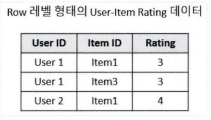



In [17]:
!pip install numpy<2.0

/bin/bash: line 1: 2.0: No such file or directory


In [2]:
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split

- Surprise는 무비렌즈(MovieLens) 사이트에서 제공하는 과거 버전의 데이터 세트를 가져오는 API 제공
- load_builtin()은 무비렌즈 사이트에서 제공하는 과거 버전 데이터 세트 'ml-100k'/'ml-lm' 데이터를 아카이브 사이트로부터 내려받아 로컬 디렉터리에 저장한 뒤 데이터를 로딩


In [3]:
data = Dataset.load_builtin('ml-100k')
# 수행 시마다 동일하게 데이터를 분할하기 위해 random_state 값 부여
trainset, testset = train_test_split(data, test_size=.25, random_state=0)

Dataset ml-100k could not be found. Do you want to download it? [Y/n] Y
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


Surprise 사용자-아이템 평점 데이터 적용할 때 주의할 점

- 무비렌즈 사이트에서 내려받은 데이터 파일과 동일하게 로우 레벨의 사용자-아이템 평점 데이터를 그대로 적용
- Surprise는 자체적으로 로우 레벨의 데이터를 칼럼 레벨의 데이터로 변경

In [4]:
# SVD로 잠재 요인 협업 필터링 수행
# 알고리즘 객체 생성 후 객체에 fit을 수행해 학습 데이터 세트 기반으로 추천 알고리즘 학습
algo = SVD(random_state=0)
algo.fit(trainset)

- test(): 사용자-아이템 평점 데이터 세트 전체에 대해 추천 예측하는 메서드
- predict(): 개별 사용자와 영화에 대한 추천 평점 반환

In [5]:
# 학습된 추천 알고리즘 기반 텍스트 데이터 세트에 대해 추천 수행: test()
predictions = algo.test(testset)
print('prediction type :', type(predictions), 'size:', len(predictions))
print('prediction 결과의 최초 5개 추출')
predictions[:5]

prediction type : <class 'list'> size: 25000
prediction 결과의 최초 5개 추출


[Prediction(uid='120', iid='282', r_ui=4.0, est=3.5114147666251547, details={'was_impossible': False}),
 Prediction(uid='882', iid='291', r_ui=4.0, est=3.573872419581491, details={'was_impossible': False}),
 Prediction(uid='535', iid='507', r_ui=5.0, est=4.033583485472447, details={'was_impossible': False}),
 Prediction(uid='697', iid='244', r_ui=5.0, est=3.8463639495936905, details={'was_impossible': False}),
 Prediction(uid='751', iid='385', r_ui=4.0, est=3.1807542478219157, details={'was_impossible': False})]

- Prediction 객체: Surprise 패키지에서 제공하는 데이터 타입, 개별 사용자 아이디(uid), 영화(또는 아이템) 아이디와 실제 평점(r_ui) 정보에 기반해 추천 예측 평점(est) 데이터를 튜플 형태로 가짐
- 'was_impossible' = True => 예측값 생성할 수 없는 데이터

In [6]:
[ (pred.uid, pred.iid, pred.est) for pred in predictions[:3] ]

[('120', '282', 3.5114147666251547),
 ('882', '291', 3.573872419581491),
 ('535', '507', 4.033583485472447)]

In [7]:
# 학습된 추천 알고리즘 기반 텍스트 데이터 세트에 대해 추천 수행: predict()
# 사용자 아이다, 아이템 아이디는 문자열로 입력해야 함
uid = str(196)
iid = str(302)
pred = algo.predict(uid, iid)
print(pred)

user: 196        item: 302        r_ui = None   est = 4.49   {'was_impossible': False}


In [8]:
# RMSE 평가 결과 확인
accuracy.rmse(predictions)

RMSE: 0.9467


0.9466860806937948



> **Surprise 주요 모듈 소개**
- [Dataset]
  - user_id(사용자 아이디), item_id(아이템 아이디), rating(평점) 데이터가 로우 레벨로 된 데이터 세트만 적용 가능
  - 앞 3개 필드만 로딩, 4번째 칼럼부터는 로딩 수행 X
  - 무비렌즈 아카이브 서버에서 자동으로 내려받는 파일뿐만 아니라 일반 데이터 파일/판다스 DataFrame에서도 로딩 가능(칼럼 순서: 사용자 아이디-아이템 아이디-평점)
- [OS 파일 데이터를 Surprise 데이터 세트로 로딩]
  - 로딩되는 데이터 파일에 칼럼명을 가지는 헤더 문자열이 있어서는 안됨
  - to_csv() 함수로 칼럼 헤더 삭제 후 새로운 파일로 저장



In [9]:
import pandas as pd

ratings = pd.read_csv('/content/drive/MyDrive/ESAA/input/ml-latest-small/ratings.csv')
# ratings_noh.csv 파일로 업로드 시 인덱스와 헤더를 모두 제거한 새로운 파일 생성.
ratings.to_csv('/content/drive/MyDrive/ESAA/input/ml-latest-small/ratings.csv', index=False, header=False)

- ratings_noh.csv: ratings.csv 파일에서 헤더가 삭제된 파일
- Reader 클래스로 데이터 파일 픽싱 포맷 정의 후 Datset.load_from_file() 적용
- Reader 클래스: 로딩될 파일의 파싱 정보를 알려주기 위해 사용 => 클래스의 생성자에 각 필드의 칼럼명과 칼럼 분리문자, 최소-최대 평점을 입력해 객체 생성
- load_from_file()로 생성된 Reader 객체 참조해 데이터 파일 파싱하면서 로딩

In [10]:
from surprise import Reader

reader = Reader(line_format = 'user item rating timestamp', sep=',', rating_scale=(0.5, 5))
data = Dataset.load_from_file('/content/drive/MyDrive/ESAA/input/ml-latest-small/ratings.csv', reader=reader)

- *line_format (string)*: 칼럼 순서대로 나열 => 입력된 문자열 공백으로 분리해 칼럼으로 인식
- *sep (char)*: 칼럼 분리하는 분리자. 디폴트는 '|t'
- *rating_scale (tuple, optional)*: 평점 값의 최소 ~ 최대 평점을 설정. 디폴트는 (1, 5)

In [11]:
trainset, testset = train_test_split(data, test_size=.25, random_state=0)

# 수행 시마다 동일한 결과를 도출하기 위해 random_state 설정
algo = SVD(n_factors = 50, random_state=0)

# 학습 데이터 세트로 학습하고 나서 텍스트 데이터 세트로 평점 예측 후 RMSE 평가
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.8682


0.8681952927143516

> **Surprise 주요 모듈 소개**
- [판다스 DataFrame에서 Surprise 데이터 세트로 로딩]
  - Dataset.load_from_df()로 판다스 DataFrame에서 Surprise 데이터 세트로 로딩
  - 사용자 아이디, 아이템 아이디, 평점 칼럼 순서를 지켜야 함
```
Dataset.load_from_df(ratings[[,iiserld,, 'movield', 'rating']], reader)
```



In [13]:
import pandas as pd
from surprise import Reader, Dataset


ratings = pd.read_csv('/content/drive/MyDrive/ESAA/input/ml-latest-small/ratings.csv')
reader = Reader(rating_scale=(0.5, 5.0))

ratings = ratings.rename(columns={
    '1': 'userId',
    '1.1': 'movieId',
    '4.0': 'rating'
})

# ratings DataFrame 에서 컬럼은 사용자 아이디, 아이템 아이디, 평점 순서를 지켜야 합니다.
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=.25, random_state=0)


algo = SVD(n_factors=50, random_state=0)
algo.fit(trainset)
predictions = algo.test( testset )
accuracy.rmse(predictions)

RMSE: 0.8708


0.8708344753692029



> **Surprise 추천 알고리즘 클래스**
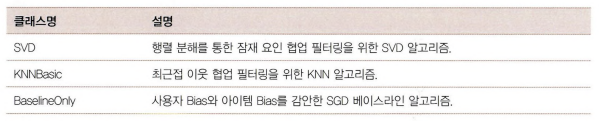

- Surprise SVD 비용 함수: 사용자 베이스라인(Baseline) 편향성을 감안한 평점 예측에 Regularization 적용한 것

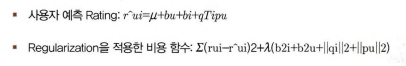





- SVD 클래스 입력 파라미터

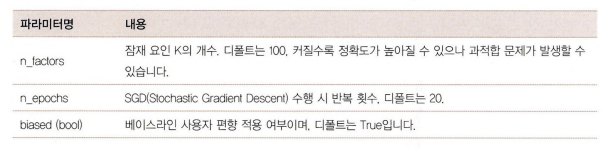

- 추천 알고리즘 예측 성능 벤치마크 결과 (Core i5 7th gen(2.5 GHz), 8G RAM 상에서 100k 데이터 세트로 테스트)
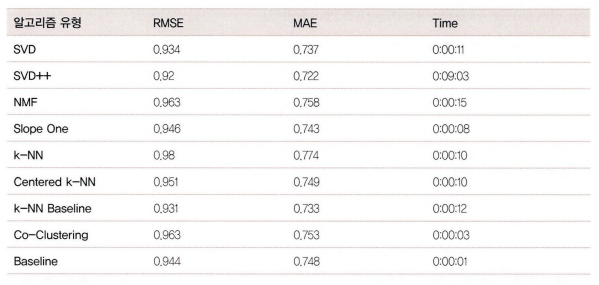



> **베이스라인 평점**
- 베이스라인 평점(Baseline Rating): 개인의 성향을 반영해 아이템 평가에 편향성(bias) 요소를 반영하여 평점을 부과하는 것
- 전체 평균 평점 + 사용자 편향 점수 + 아이템 편향 점수 공식
  - 전체 평균 평점 = 모든 사용자의 아이템에 대한 평점을 평균한 값
  - 사용자 편향 점수 = 사용자별 아이템 평점 평균 값 - 전체 평균 평점
  - 아이템 편향 점수 = 아이템별 평점 평균 값 - 전체 평균 평점
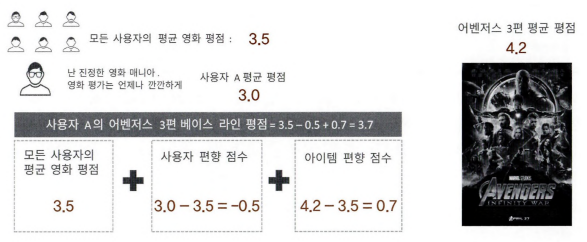



> **교차 검증과 하이퍼 파라미터 튜닝**
- cross_validate(), GridSearchCV 클래스 제공
- cross_validate(): surprise.model_selection 모듈 내에 존재하며 폴드된 데이터 세트의 개수와 성능 측정 방법을 명시해 교차 검증 수행



In [14]:
from surprise.model_selection import cross_validate

# 판다스 DataFrame에서 Surprise 데이터 세트로 데이터 로딩

ratings = pd.read_csv('/content/drive/MyDrive/ESAA/input/ml-latest-small/ratings.csv')
reader = Reader(rating_scale=(0.5, 5.0))

ratings = ratings.rename(columns={
    '1': 'userId',
    '1.1': 'movieId',
    '4.0': 'rating'
})

data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

algo = SVD(random_state=0)
cross_validate(algo, data, measures = ['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8777  0.8680  0.8743  0.8712  0.8770  0.8736  0.0036  
MAE (testset)     0.6750  0.6651  0.6732  0.6683  0.6715  0.6706  0.0035  
Fit time          0.99    1.01    0.97    0.90    0.94    0.96    0.04    
Test time         0.07    0.20    0.07    0.16    0.07    0.11    0.06    


{'test_rmse': array([0.87771123, 0.86802969, 0.8742992 , 0.87119911, 0.87697782]),
 'test_mae': array([0.67502635, 0.66507771, 0.67319663, 0.6683093 , 0.67145322]),
 'fit_time': (0.9911773204803467,
  1.0074522495269775,
  0.9677646160125732,
  0.9008674621582031,
  0.9446756839752197),
 'test_time': (0.06954360008239746,
  0.2024552822113037,
  0.06952762603759766,
  0.16302776336669922,
  0.06975030899047852)}

In [15]:
from surprise.model_selection import GridSearchCV

# 최적화할 파라미터를 딕셔너리 형태로 지정
param_grid = {'n_epochs' : [20,40,60], 'n_factors':[50,100,200]}

# CV를 3개 폴드 세트로 지정, 성능 평가는 rmse, mse 로 수행하도록 GridSearchCV 구성
gs = GridSearchCV(SVD, param_grid, measures = ['rmse', 'mae'], cv=3)
gs.fit(data)

# 최고 RMSE Evaluation 점수와 그때의 하이퍼 파라미터
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.8771433748373422
{'n_epochs': 20, 'n_factors': 50}




> **Surprise를 이용한 개인화 영화 추천 시스템 구축**
- Surprise 패키지로 학습된 추천 알고리즘을 기반으로 특정 사용자가 아직 평점을 매기지 않은(관람하지 않은) 영화 중에서 개인 취향에 가장 적절한 영화를 추천





```
# 다음 코드는 train_test_split()으로 분리되지 않는 데이터 세트에 fit()을 호출해 오류가 발생

data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
algo = SVD(n_factors=50, random_state=0)
algo.fit(data)
```



In [16]:
from surprise.dataset import DatasetAutoFolds

reader = Reader(line_format = 'user item rating timestamp', sep=',', rating_scale=(0.5, 5))
# DatasetAutoFolds 클래스를 ratings_noh.csv 파일 기반으로 생성
data_folds = DatasetAutoFolds(ratings_file = '/content/drive/MyDrive/ESAA/input/ml-latest-small/ratings.csv', reader= reader)

# 전체 데이터를 학습 데이터로 생성함
trainset = data_folds.build_full_trainset()

In [17]:
# SVD 이용해 학습 수행
algo = SVD(n_epochs=20, n_factors=50, random_state=0)
algo.fit(trainset)

In [19]:
# 특정 사용자 userId=9인 사용자로 지정
# 영화에 대한 상세 속성 정보 DataFrame 로딩
movies = pd.read_csv('/content/drive/MyDrive/ESAA/input/ml-latest-small/movies.csv')

# userId = 9의 movieId 데이터를 추출해 movieId=42 데이터가 있는지 확인
movieIds = ratings[ratings['userId']==9]['movieId']

if movieIds[movieIds == 42].count() == 0:
    print('사용자 아이디 9는 영화 아이디 42의 평점 없음')

print(movies[movies['movieId']==42])

사용자 아이디 9는 영화 아이디 42의 평점 없음
    movieId                   title              genres
38       42  Dead Presidents (1995)  Action|Crime|Drama


In [20]:
uid = str(9)
iid = str(42)

pred = algo.predict(uid, iid, verbose=True)

user: 9          item: 42         r_ui = None   est = 3.13   {'was_impossible': False}


In [21]:
# 사용자가 평점을 매기지 않은 전체 영화를 추출한 뒤 예측 평점순으로 영화를 추천
# 추천 대상이 되는 영화 추출
def get_unseen_surprise(ratings, movies, userId):
    # 입력값으로 들어온 userId에 해당하는 사용자가 평점을 매긴 모든 영화를 리스트로 생성
    seen_movies = ratings[ratings['userId']==userId]['movieId'].tolist()

    # 모든 영화의 movieid를 리스트로 생성
    total_movies = movies['movieId'].tolist()

    # 모든 영화의 movieId 중 이미 평점을 매긴 영화의 movieId를 제외한 후 리스트로 생성
    unseen_movies = [movie for movie in total_movies if movie not in seen_movies]
    print('평점 매긴 영화 수:', len(seen_movies), '추천 대상 영화 수:', len(unseen_movies), '전체 영화 수:', len(total_movies))

    return unseen_movies

unseen_movies = get_unseen_surprise(ratings, movies, 9)

평점 매긴 영화 수: 46 추천 대상 영화 수: 9696 전체 영화 수: 9742


In [22]:
# 앞에서 학습된 추천 알고리즘 클래스 SVD로 높은 예측 평점을 가진 순으로 영화를 추천

def recomm_movie_by_surprise(algo, userId, unseen_movies, top_n=10):
    # 알고리즘 객체의 predict() 메서드를 평점이 없는 영화에 반복 수행한 후 결과를 list 객체로 저장
    predictions = [algo.predict(str(userId), str(movieId)) for movieId in unseen_movies]

    # predictions list 객체는 surprise의 Predictions 객체를 원소로 가지고 있음.
    # [Prediction(uid='9', iid='1', est=3.69), Prediction(uid='9', iid='2', est=2.98),,,,]
    # 이를 est 값으로 정렬하기 위해서 아래의 sortkey_est 함수를 정의함.
    # sortkey_est 함수는 list 객체의 sort() 함수의 키 값으로 사용되어 정렬 수행.
    def sortkey_est(pred):
        return pred.est

    # sortkey_est( ) 반환값의 내림 차순으로 정렬 수행하고 top_n개의 최상위 값 추출.
    predictions.sort(key=sortkey_est, reverse=True)
    top_predictions= predictions[:top_n]

    # top_n으로 추출된 영화의 정보 추출. 영화 아이디, 추천 예상 평점, 제목 추출
    top_movie_ids = [ int(pred.iid) for pred in top_predictions]
    top_movie_rating = [ pred.est for pred in top_predictions]
    top_movie_titles = movies[movies.movieId.isin(top_movie_ids)]['title']
    top_movie_preds = [ (id, title, rating) for id, title, rating in zip(top_movie_ids, top_movie_titles, top_movie_rating)]

    return top_movie_preds

unseen_movies = get_unseen_surprise(ratings, movies, 9)
top_movie_preds = recomm_movie_by_surprise(algo, 9, unseen_movies, top_n=10)
print('##### Top-10 추천 영화 리스트 #####')

for top_movie in top_movie_preds:
    print(top_movie[1], ":", top_movie[2])

평점 매긴 영화 수: 46 추천 대상 영화 수: 9696 전체 영화 수: 9742
##### Top-10 추천 영화 리스트 #####
Usual Suspects, The (1995) : 4.306302135700814
Star Wars: Episode IV - A New Hope (1977) : 4.281663842987387
Pulp Fiction (1994) : 4.278152632122759
Silence of the Lambs, The (1991) : 4.226073566460876
Godfather, The (1972) : 4.1918097904381995
Streetcar Named Desire, A (1951) : 4.154746591122657
Star Wars: Episode V - The Empire Strikes Back (1980) : 4.122016128534504
Star Wars: Episode VI - Return of the Jedi (1983) : 4.108009609093436
Goodfellas (1990) : 4.083464936588478
Glory (1989) : 4.07887165526957




---



#### **09** 정리

- 추천 시스템은 기업 애플리케이션 특히 온라인 스토어에서 매출 향상으로 이어지는 많은 사례가 있음
- 대표적 방식 콘텐츠 기반 필터링, 협업 필터링
  - 콘텐츠 기반 필터링: 아이템(상품, 영화, 서비스 등) 구성하는 여러 가지 콘텐츠 중 사용자가 좋아하는 콘텐츠 필터링하여 이에 맞는 아이템 추천
  - 협업 필터링: 최근접 이웃 필터링/잠재 요인 협업 필터링
    
    - 최근접 이웃 필터링: 사용자 기반(사용자-사용자), 아이템 기반(아이템-아이템_
    - 잠재 요인 협업 필터링: 사용자-아이템 평점 행렬 데이터에 숨어 있는 잠재 요인을 추출하여 사용자가 아직 평점을 매기지 않은 아이템에 대한 평점을 예측하고 이를 추천에 반영
- Surprise: 사이킷런과 유사한 API를 지향, 간단한 API만으로 파이썬 기반에서 추천 시스템을 구현